In [1]:
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import norm
from joblib import Parallel, delayed

In [2]:
def FDA_SDE_kernel(bw, x):
    return norm.pdf(x / bw) / bw

def optimise_for_betahat(path_observations, time_points, bandwidth, local_poly_smooth_order, num_paths, num_time_points):
    # Note we assume we want to estimate the drift function at the same points as the ones we observe
    assert (path_observations.shape == time_points.shape)
    assert (time_points.shape == (num_paths, num_time_points))
    # Note we assume all paths have the same number of observations and are defined on the same grid size (FOR NOW)
    assert (np.allclose(time_points, time_points[[0], :]))
    eval_time_points = time_points[0, :]
    T_data = time_points.reshape(num_paths, num_time_points, 1, 1) - time_points
    assert np.all([np.allclose(T_data[:,:, i, j], time_points-time_points[i, j]) for i in range(num_time_points) for j in range(num_time_points)])
    # Bethat is the OLS parameter vector from regression path_observations against polynomial expansion of time differences
    assert (T_data.shape == (num_paths, num_time_points, num_paths, num_time_points))
    X_data = np.stack([np.power(T_data, p) for p in range(local_poly_smooth_order+1)])
    assert (X_data.shape == (local_poly_smooth_order + 1, num_paths, num_time_points, num_paths, num_time_points))
    X_flat = X_data.reshape((X_data.shape[0], np.prod(X_data.shape[1:]))).T
    Y = np.vstack([path_observations]*(num_paths*num_time_points))
    assert (Y.shape == (num_paths*num_time_points, num_paths, num_time_points))
    Y_flat = Y.flatten()

    kernel_weights = np.sqrt(FDA_SDE_kernel(bw=bandwidth, x=T_data))
    assert (kernel_weights.shape == (num_paths, num_time_points, num_paths, num_time_points))
    betas = sm.WLS(Y_flat, X_flat, weights=kernel_weights.flatten()).fit().params.reshape(-1, 1)
    assert (betas.shape == (local_poly_smooth_order + 1, 1))
    return betas, eval_time_points

def per_t_optimise_for_betahat(path_observations, time_points, bandwidth, local_poly_smooth_order, num_paths, num_time_points):
    # Note we assume we want to estimate the drift function at the same points as the ones we observe
    assert (path_observations.shape == time_points.shape)
    assert (time_points.shape == (num_paths, num_time_points))
    # Note we assume all paths have the same number of observations and are defined on the same grid size (FOR NOW)
    assert (np.allclose(time_points, time_points[[0], :]))
    betas = np.zeros((num_time_points,local_poly_smooth_order + 1))
    eval_time_points = time_points[0, :]
    for tidx in range(num_time_points):
        t = eval_time_points[tidx]
        # Bethat is the OLS parameter vector from regression path_observations against polynomial expansion of time differences
        T_data = time_points - t
        assert (T_data.shape == (num_paths, num_time_points))
        X_data = np.stack([np.power(T_data, p) for p in range(local_poly_smooth_order+1)])
        assert (X_data.shape == (local_poly_smooth_order + 1, num_paths, num_time_points))
        X_flat = X_data.reshape((X_data.shape[0], np.prod(X_data.shape[1:]))).T
        Y_flat = path_observations.flatten()
        kernel_weights = np.sqrt(FDA_SDE_kernel(bw=bandwidth, x=T_data))
        assert (kernel_weights.shape == (num_paths, num_time_points))
        betas[tidx, :] = sm.WLS(Y_flat, X_flat, weights=kernel_weights.flatten()).fit().params
    assert (betas.shape == (num_time_points, local_poly_smooth_order + 1))
    mean_hat_t = betas[:,0]
    assert (mean_hat_t.shape == (num_time_points, ))
    delta_mean_hat_t = betas[:, 1] / bandwidth
    assert (delta_mean_hat_t.shape == (num_time_points, ))
    # 2.3: For now, we can assume the diffusion function is known for convenience (and possibly easier implementation)
    # true_cov = np.nan # TODO
    # cov_hat_t = true_cov
    return mean_hat_t,delta_mean_hat_t, eval_time_points

def estimate_drift_from_iid_paths(eval_time_points, mean_hat_t, delta_mean_hat_t, num_time_points):
    # Step 3: Plug-in estimators
    # 3.1: From Step 2, we can consistently recover the mean and covariance functions of the latent process together with their derivatives
    # 3.2: We plug these into Eq (3.5) i.e., Eq (3.14) to transform global information to local information in the form of drift and diffusion functions
    assert (eval_time_points.shape[0] == num_time_points)
    drift_hats = np.zeros((num_time_points, ))
    for tidx in range(num_time_points):
        drift_hat_t = 0. if mean_hat_t[tidx] == 0. else delta_mean_hat_t[tidx] * 1./mean_hat_t[tidx]
        drift_hats[tidx] = drift_hat_t
    return drift_hats

def gaussian_kernel(bw, x):
    return norm.pdf(x / bw) / bw

# Drift estimation function
def cv_nadaraya_watson_estimate_drift(x0, path, delta_X, c_const):
    h = c_const*(path.shape[0] ** (-0.2))
    path_incs = np.diff(path)
    weights = gaussian_kernel(x=(path[:-1] - x0), bw=h)
    numerator = np.sum(weights * path_incs)
    denominator = np.sum(weights)
    return numerator / (delta_X * denominator) if denominator != 0 else 0

In [3]:
end_diff_time = 1.
start_diff_time = 0.
ts_length = 256
Delta = 1./ts_length
# Drift parameters
mean_rev = 1.

In [4]:
path_observations = np.load(project_config.ROOT_DIR + "data/fSin_samples_H05_T256_10Rev_10Diff_00Init.npy")[:400,:]
prevPath_observations = np.concatenate([np.zeros((path_observations.shape[0],1)), path_observations[:,:-1]],axis=1)
path_incs = np.concatenate([path_observations[:, [0]], np.diff(path_observations, axis=1)], axis=1)
assert (prevPath_observations.shape == path_observations.shape == path_incs.shape)
assert (prevPath_observations.shape[1] == ts_length)

In [5]:
def IID_NW_estimator(prevPath_observations, path_incs, bw, x, end_diff_time, start_diff_time):
    N, n = prevPath_observations.shape
    kernel_weights_unnorm = gaussian_kernel(bw=bw, x=prevPath_observations[:, :, np.newaxis] - x)
    denominator = np.sum(kernel_weights_unnorm, axis=(1,0)) / (N*n)
    numerator = np.sum(kernel_weights_unnorm * path_incs[:, :, np.newaxis], axis=(1,0)) / N*(end_diff_time - start_diff_time)
    return numerator/denominator

def bandwidth_selection(prevPath_observations, path_incs, end_diff_time, start_diff_time, Delta):
    bws = np.logspace(-2, 0, 5)
    mask = np.ones(prevPath_observations.shape[0], dtype=bool)
    CVs = []
    for _bw in bws:
        cv = 0
        for i in tqdm(range(prevPath_observations.shape[0])):
            ppath = prevPath_observations[i,:]
            mask[i] = False
            estimator = IID_NW_estimator(prevPath_observations=prevPath_observations[mask, :], path_incs = path_incs[mask,:],bw=_bw,x=ppath, end_diff_time=end_diff_time, start_diff_time=start_diff_time)
            mask[i] = True
            cv += np.sum(estimator **2 * Delta - 2*estimator*path_incs[i,:])
            if np.isnan(cv):
                cv = np.inf
                break
        print(cv)
        CVs.append(cv)
    print(CVs, np.argmin(CVs))
    bw = bws[np.argmin(CVs)]
    print(bw)
    return bw
#bw = bandwidth_selection(prevPath_observations=prevPath_observations, path_incs=path_incs, end_diff_time=end_diff_time, start_diff_time=start_diff_time, Delta=Delta)

In [6]:
assert (prevPath_observations.shape[1]*Delta == (end_diff_time-start_diff_time))

In [7]:
def compute_cv_for_bw_per_path(i, _bw):
    N = prevPath_observations.shape[0]
    mask = np.arange(N) != i
    estimator = IID_NW_estimator(
        prevPath_observations=prevPath_observations[mask, :],
        path_incs=path_incs[mask, :],
        bw=_bw,
        x=prevPath_observations[i, :],
        end_diff_time=end_diff_time,
        start_diff_time=start_diff_time
    )
    residual = estimator**2 * Delta - 2 * estimator * path_incs[i, :]
    cv = np.sum(residual)
    if np.isnan(cv):
        return np.inf
    return cv

def compute_cv_for_bw(_bw):
    N = prevPath_observations.shape[0]
    cvs = Parallel(n_jobs=8)(delayed(compute_cv_for_bw_per_path)(i, _bw) for i in (range(N)))
    return np.sum(cvs)

bws = np.logspace(-2, 0, 20)
mask = np.ones(prevPath_observations.shape[0], dtype=bool)
CVs = np.zeros(len(bws))
for h in tqdm(range(bws.shape[0])):
    CVs[h] = compute_cv_for_bw(bws[h])


  5%|▌         | 1/20 [05:16<1:40:10, 316.32s/it]
Exception ignored in: <generator object tqdm.__iter__ at 0x138d40120>
Traceback (most recent call last):
  File "/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/tqdm/std.py", line 1193, in __iter__
    self.close()
  File "/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/tqdm/std.py", line 1300, in close
    fp_write('\n')
  File "/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/tqdm/std.py", line 1284, in fp_write
    self.fp.write(str(s))
  File "/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/tqdm/utils.py", line 127, in inner
    return func(*args, **kwargs)
  File "/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/ipykernel/iostream.py", line 646, in write
    self._schedule_flush()
  File "/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/pyth

KeyboardInterrupt: 

In [ ]:
bw = bws[np.argmin(CVs)]
CVs

In [45]:
Xs = np.linspace(-2, 2, 100)
drift_hats = np.zeros((100, 50))
ddata = np.load(project_config.ROOT_DIR + "data/fSin_samples_H05_T256_10Rev_10Diff_00Init.npy")
idxs = np.arange(ddata.shape[0])
for k in tqdm(range(50)):
    path_observations = ddata[np.random.choice(idxs, size=100000, replace=False),:]
    prevPath_observations = np.concatenate([np.zeros((path_observations.shape[0],1)), path_observations[:,:-1]],axis=1)
    path_incs = np.concatenate([path_observations[:, [0]], np.diff(path_observations, axis=1)], axis=1)
    drift_hats[:,k] = IID_NW_estimator(prevPath_observations=prevPath_observations, bw=bw, x=Xs, path_incs=path_incs, end_diff_time=end_diff_time, start_diff_time=start_diff_time)

100%|██████████| 1200/1200 [04:07<00:00,  4.85it/s]


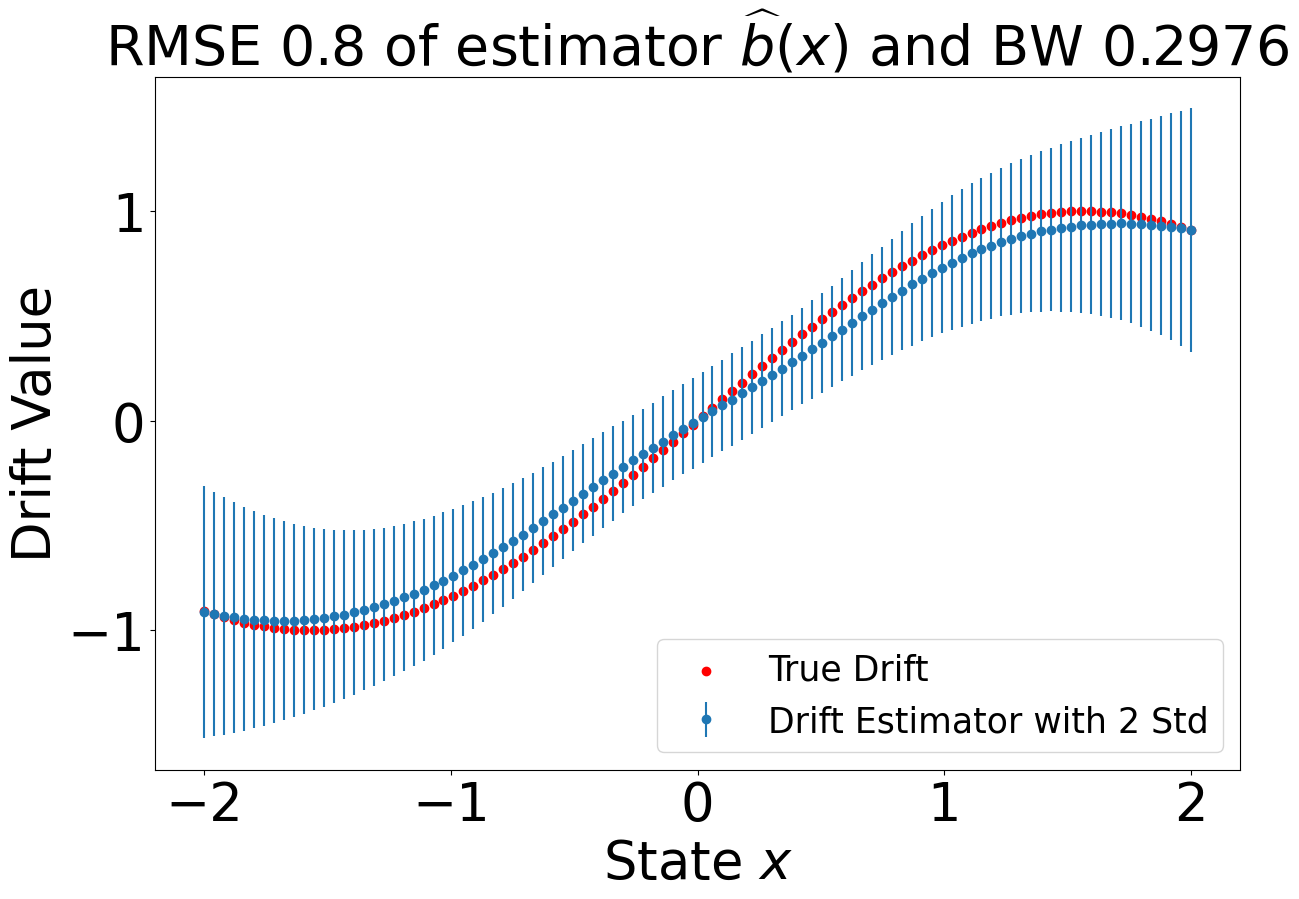

0.8001947846958261


In [50]:
fig, ax = plt.subplots(figsize=(14, 9))
mean_drift_hats = np.mean(drift_hats, axis=1)
rmse = np.linalg.norm(mean_drift_hats-np.sin(Xs))
std = np.std(drift_hats, axis=1)
plt.scatter(Xs, np.sin(Xs), color="red", label="True Drift")
plt.errorbar(Xs, mean_drift_hats,fmt="o", yerr=2*std, label="Drift Estimator with 2 Std")
ax.set_title(rf"RMSE {round(rmse,3)} of estimator $\widehat{{b}}(x)$ and BW {round(bw,4)}", fontsize=40)
ax.tick_params(labelsize=38)
ax.set_xlabel("State $x$", fontsize=38)
ax.set_ylabel("Drift Value", fontsize=38)
ax.legend(loc="lower right", fontsize=25)
plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/benchmark_sinusoidal.png", bbox_inches='tight')
plt.show()
plt.close()
print(rmse)